<a href="https://colab.research.google.com/github/AnishTeku/AnishTeku-Assignment-3/blob/main/Assignment_3_Large_language_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [65]:
# Install Required Libraries
!pip install transformers datasets

In [66]:
# Import Necessary Libraries
from transformers import BertForSequenceClassification, BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import numpy as np
import pandas as pd

In [67]:
# Load and Explore the Dataset
rotten_ds = load_dataset("cornell-movie-review-data/rotten_tomatoes")

In [68]:
print(rotten_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [69]:
# Convert the dataset to pandas DataFrames for easier exploration
df_train = pd.DataFrame(rotten_ds["train"])
df_validation = pd.DataFrame(rotten_ds["validation"])
df_test = pd.DataFrame(rotten_ds["test"])

print("Train set:", df_train.head())
print("Validation set:", df_validation.head())
print("Test set:", df_test.head())

Train set:                                                 text  label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1
Validation set:                                                 text  label
0  compassionately explores the seemingly irrecon...      1
1  the soundtrack alone is worth the price of adm...      1
2  rodriguez does a splendid job of racial profil...      1
3  beneath the film's obvious determination to sh...      1
4    bielinsky is a filmmaker of impressive talent .      1
Test set:                                                 text  label
0  lovingly photographed in the manner of a golde...      1
1              consistently clever and suspenseful .      1
2  it's like a " big chill " reunion of the baade...      1
3  

In [83]:
print("\nLabel distribution in the train set:")
print(df_train["label"].value_counts())

print("\nLabel distribution in the validation set:")
print(df_validation["label"].value_counts())

print("\nLabel distribution in the test set:")
print(df_test["label"].value_counts())


Label distribution in the train set:
label
1    4265
0    4265
Name: count, dtype: int64

Label distribution in the validation set:
label
1    533
0    533
Name: count, dtype: int64

Label distribution in the test set:
label
1    533
0    533
Name: count, dtype: int64


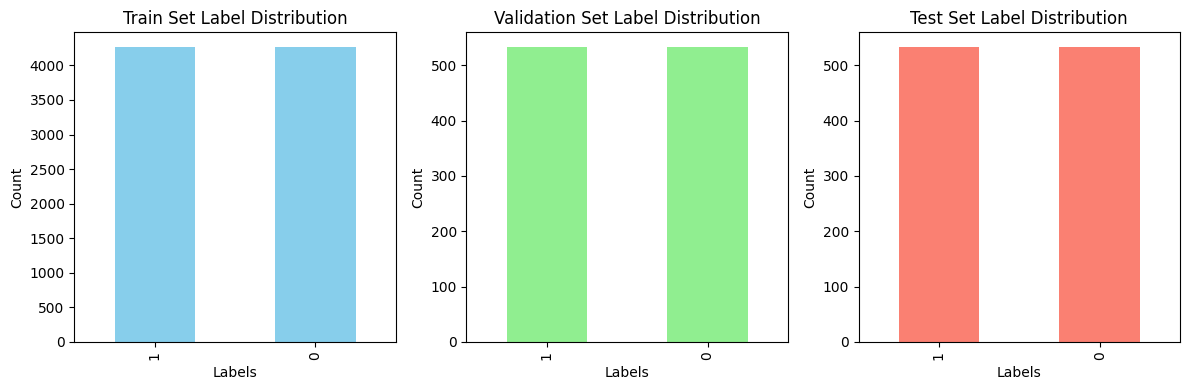

In [84]:
import matplotlib.pyplot as plt

# Plotting the label distribution for the train set
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df_train["label"].value_counts().plot(kind='bar', color='skyblue')
plt.title("Train Set Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")

# Plotting the label distribution for the validation set
plt.subplot(1, 3, 2)
df_validation["label"].value_counts().plot(kind='bar', color='lightgreen')
plt.title("Validation Set Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")

# Plotting the label distribution for the test set
plt.subplot(1, 3, 3)
df_test["label"].value_counts().plot(kind='bar', color='salmon')
plt.title("Test Set Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [71]:
# Experimenting with BERT Transformer Models
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [72]:
# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

tokenized_datasets = rotten_ds.map(tokenize_function, batched=True)

# Rename the label column to labels
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Data collator that handles masking
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15, return_tensors='pt'
)

In [73]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors='pt')

In [74]:
# Load the model with two labels for classification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
# Enable gradient checkpointing to reduce memory usage
model.gradient_checkpointing_enable()

# Set up training arguments with reduced batch size and mixed precision
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,

    # Reduce batch size
    per_device_train_batch_size=4,

    # Reduce batch size for evaluation
    per_device_eval_batch_size=4,

    # Enable mixed precision
    fp16=True,

    # Accumulate gradients
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [76]:
from datasets import load_metric
import numpy as np

# Load the accuracy metric
accuracy_metric = load_metric("accuracy")

# Function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [77]:
from transformers import Trainer

trainer = Trainer(
    # The BERT model we initialized earlier
    model=model,

    # Training arguments
    args=training_args,

    # Training dataset
    train_dataset=tokenized_datasets['train'],

    # Validation dataset
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

    # Data collator that handles dynamic padding and masking
    data_collator=data_collator
)

In [78]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.541200,0.385931,0.854597
2,0.313700,0.550432,0.863977
4,0.059400,1.049389,0.857411
6,0.000100,1.132881,0.857411
8,0.000000,1.282907,0.855535
9,0.000000,1.303619,0.856473


TrainOutput(global_step=10660, training_loss=0.1081898420657718, metrics={'train_runtime': 2079.0781, 'train_samples_per_second': 41.028, 'train_steps_per_second': 5.127, 'total_flos': 2.243337480210432e+16, 'train_loss': 0.1081898420657718, 'epoch': 9.995311767463667})

In [79]:
# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)
print(f"Accuracy: {evaluation_results['eval_accuracy']:.4f}")

Evaluation Results: {'eval_loss': 1.3036185503005981, 'eval_accuracy': 0.8564727954971857, 'eval_runtime': 4.983, 'eval_samples_per_second': 213.929, 'eval_steps_per_second': 53.582, 'epoch': 9.995311767463667}
Accuracy: 0.8565


In [91]:
import torch

# Identify the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the identified device
model.to(device)

# List of sample texts for prediction
sample_texts = [
    "This movie was absolutely fantastic! I loved every moment of it.",
    "I hated this movie. It was a complete waste of time.",
    "The film was okay, but nothing special.",
    "The plot was dull and the acting was terrible.",
    "An excellent movie with a well-crafted storyline and superb performances."
]

# Create a list to hold the predictions
predictions = []

# Iterate over each sample text and make predictions
for sample_text in sample_texts:
    # Tokenize the sample text and move inputs to the same device
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    # Make prediction with the fine-tuned model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)

    # Extract logits (raw model outputs)
    logits = outputs.logits

    # Convert logits to predictions (0 or 1)
    predicted_class = logits.argmax(dim=-1).item()

    # Map the prediction to human-readable labels
    label_map = {0: "Negative", 1: "Positive"}
    predicted_label = label_map[predicted_class]

    # Add the result to the predictions list
    predictions.append((sample_text, predicted_label))

# Print the arranged predictions
print("Predictions for Sample Texts:\n")
for i, (text, label) in enumerate(predictions, 1):
    print(f"{i}. Text: {text}")
    print(f"   Predicted Sentiment: {label}")
    print("-" * 80)


Predictions for Sample Texts:

1. Text: This movie was absolutely fantastic! I loved every moment of it.
   Predicted Sentiment: Positive
--------------------------------------------------------------------------------
2. Text: I hated this movie. It was a complete waste of time.
   Predicted Sentiment: Negative
--------------------------------------------------------------------------------
3. Text: The film was okay, but nothing special.
   Predicted Sentiment: Negative
--------------------------------------------------------------------------------
4. Text: The plot was dull and the acting was terrible.
   Predicted Sentiment: Negative
--------------------------------------------------------------------------------
5. Text: An excellent movie with a well-crafted storyline and superb performances.
   Predicted Sentiment: Positive
--------------------------------------------------------------------------------
